In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from math import sqrt, pi, exp, erf
from numpy import vectorize

In [2]:
# Boundaries of x0 grid
bounds_x0 = (-10, 10)

# Number of X0 grid points
Nx0 = 20

# The x0 grid interval
dx0 = (bounds_x0[1] - bounds_x0[0])/Nx0

# Boundaries of t grid
bounds_t = (0, 10)

# Number of t grid points
Nt = 100

# The t grid interval
dt = (bounds_t[1] - bounds_t[0])/Nt

# Initial Probability Distribution Variables
mu = 0
sigma = 1

# Constants of the experiment
h = 1
mass = 1
h2_m = h*h/mass

# Initial kinetic energy (used to determine velocity)
K0 = 5

print(dx0)
print(dt)

1.0
0.1


In [3]:
# Utility function to generate gradient matrices
def grad_matrix(forward, central, backward):
    mat = np.zeros((Nx0, Nx0), dtype = np.longdouble)
    mat[0][0:5] = forward
    mat[1][1:6] = forward
    mat[-2][-6:-1] = backward
    mat[-1][-5:] = backward
    for i in range(2, Nx0-2):
        mat[i][i-2:i-2+5] = central
    
    return mat

# Create spatial gradient operators (1st to 4th order)
derive_1 = 1/(12*dx0) * grad_matrix([-25, 48, -36, 16, -3], [1, -8, 0, 8, -1], [3, -16, 36, -48, 25])
derive_2 = 1/(12*(dx0**2)) * grad_matrix( [35, -104, 114, -56, 11], [-1, 16, -30, 16, -1], [11, -56, 114, -104, 35])
derive_3 = 1/(2*(dx0**3)) * grad_matrix([-5, 18, -24, 14, -3], [-1, 2, 0, -2, 1], [3, -14, 24, -18, 5])
derive_4 = 1/(dx0**4) * grad_matrix([1, -4, 6, -4, 1], [1, -4, 6, -4, 1], [1, -4, 6, -4, 1])

In [4]:
# Coefficient to obtain truncated Gaussian
C = 0.5 * (erf((bounds_x0[1])/(sigma*sqrt(2))) - erf((bounds_x0[0])/(sigma*sqrt(2))))

# Computes a truncated Gaussian w.r.t bounds_x0, sigma, and mu.
def gaussian(x):
    return 1/(C*sigma*sqrt(2*pi)) * exp(-0.5*((x-mu)/sigma)**2) if bounds_x0[0] <= x <= bounds_x0[1] else 0

# Computes the classical potential
def potential(x):
    return 0

# Computes the classical force (-grad(V))
def force(x):
    return 0

# Computes the initial quantum potential
def initial_quantum_potential(x):
    return -0.5 * h2_m * ratio2(x)

# Computes the initial quantum force
def initial_quantum_force(x):
    return -0.5 * h2_m  * -(x-mu)/(2*(sigma**4))

# Computes the initial acceleration for a particle at x
def initial_acceleration(x):
    return 1/mass * (force(x) + initial_quantum_force(x))

# Computes the initial R function at time t=0
def R0(x):
    return sqrt(gaussian(x))

# Computes the ratio R0'(x)/R0(x), assuming a Gaussian distribution
def ratio1(x):
    return -0.5 * (x-mu)/(sigma*sigma)

# Computes the ratio R0"(x)/R0(x), assuming a Gaussian distribution
def ratio2(x):
    return -0.5 / (sigma*sigma) * (1 - 0.5 * (((x-mu)/sigma)**2))

In [5]:
# Utility lambda to apply functions to a set of X values
_gaussian = vectorize(gaussian)
_potential = vectorize(potential)
_force = vectorize(force)
_initial_quantum_potential = vectorize(initial_quantum_potential)
_initial_quantum_force = vectorize(initial_quantum_force)
_initial_acceleration = vectorize(initial_acceleration)
_R0 = vectorize(R0)
_ratio1 = vectorize(ratio1)
_ratio2 = vectorize(ratio2)

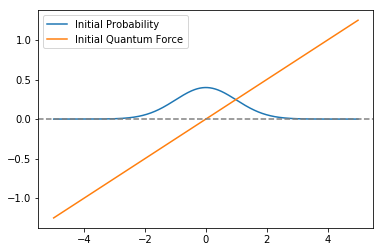

In [6]:
x_plot = np.linspace(-5, 5, 1000)
plt.plot(x_plot, _gaussian(x_plot), label="Initial Probability")
plt.plot(x_plot, _initial_quantum_force(x_plot), label="Initial Quantum Force")

plt.axhline(linestyle="--", color="gray")
plt.legend()
plt.show()

In [7]:
X, X_d, X_dd, X_p, X_pp, X_ppp, X_pppp = [np.zeros((Nt, Nx0), dtype=np.longdouble) for i in range(7)]

X[0] = np.linspace(bounds_x0[0], bounds_x0[1], Nx0, dtype=np.longdouble)
X_p[0] = np.ones((Nx0), dtype=np.longdouble)
X_d[0] = np.full((Nx0), sqrt(2*K0/mass), dtype=np.longdouble)
X_dd[0] = _initial_acceleration(X[0])

In [8]:
for i in range(1, Nt):
    # Propagate position and velocity
    X_d[i] = X_d[i-1] + (X_dd[i-1] * dt)
    X[i] = X[i-1] + (X_d[i-1] * dt) + (0.5 * X_dd[i-1] * dt * dt)
    
    # Compute spatial derivatives
    X_p[i] = derive_1 @ X[i]
    #X_pp[i] = derive_2 @ X[i]
    #X_ppp[i] = derive_3 @ X[i]
    #X_pppp[i] = derive_4 @ X[i]
    
    pos, vel, der1, der2, der3, der4 = X[i], X_d[i], X_p[i], X_pp[i], X_ppp[i], X_pppp[i]
    ratio = _ratio1(pos)
    ratio_sqr = np.square(ratio)
    
    # Compute acceleration
    X_dd[i] = 1/mass * (_force(pos) + (der1**-4) * (der1*_initial_quantum_force(pos) + 4*der2*_initial_quantum_potential(pos) + h2_m * (ratio_sqr*der2 + 3*ratio*(der2**2)/der1 - ratio*der3 - 2.5*(der2**3)/(der1**2) + 2*der2*der3/der1 - 0.25*der4)))

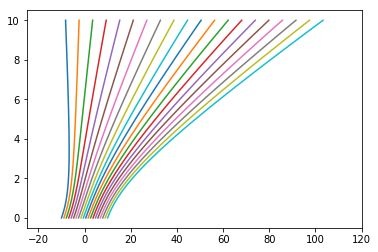

In [9]:
t_plot = np.linspace(bounds_t[0], bounds_t[1], Nt)
Xt = np.transpose(X)

for i in range(Nx0):
    plt.plot(Xt[i], t_plot)

plt.xlim(-25, 120)
plt.show()

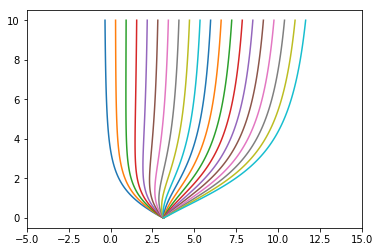

In [10]:
Xdt = np.transpose(X_d)

for i in range(Nx0):
    plt.plot(Xdt[i], t_plot)

plt.xlim(-5, 15)
plt.show()

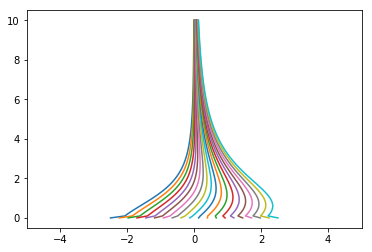

In [11]:
Xddt = np.transpose(X_dd)

for i in range(Nx0):
    plt.plot(Xddt[i], t_plot)

plt.xlim(-5, 5)
plt.show()

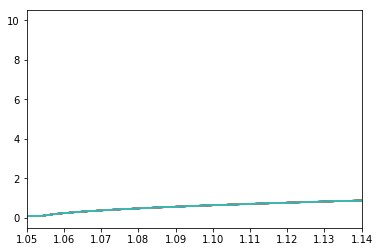

In [12]:
Xpt = np.transpose(X_p)

for i in range(Nx0):
    plt.plot(Xpt[i], t_plot)

plt.xlim(1.05, 1.14)
plt.show()

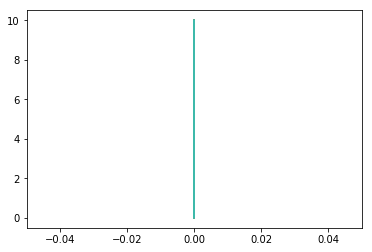

In [13]:
Xppt = np.transpose(X_pp)

for i in range(Nx0):
    plt.plot(Xppt[i], t_plot)

plt.xlim(-.05, .05)
plt.show()

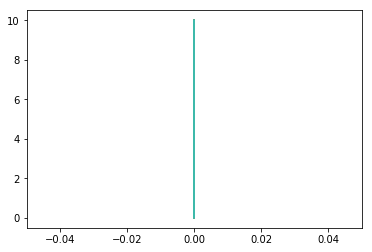

In [14]:
Xpppt = np.transpose(X_ppp)

for i in range(Nx0):
    plt.plot(Xpppt[i], t_plot)

plt.xlim(-.05, .05)
plt.show()

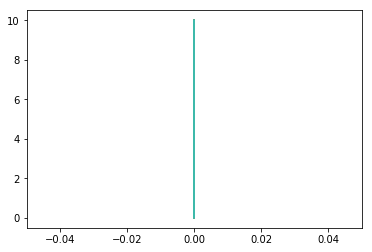

In [15]:
Xppppt = np.transpose(X_pppp)

for i in range(Nx0):
    plt.plot(Xppppt[i], t_plot)

plt.xlim(-.05, .05)
plt.show()